**NER**

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [24]:
# raot_cta_ner = pd.read_csv('ner_data.csv')
raot_cta_ner = pd.read_csv('cta_ner_standard_deviation_msa_up_to_date.csv')
print(raot_cta_ner['PROPERTY_ID'].nunique())
raot_cta_ner.head()
print(raot_cta_ner.shape)

11998
(1270861, 14)


In [25]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date = pd.to_datetime('10/09/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [26]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
419356,2022-10-03,61bc8c253eb983002a3df742,63431774c008895a8abeed04,2022-10-09,Oklahoma,f558bb7f-6cec-5f40-73ee-4794adfd38c4,"Tulsa, OK",d0cca12e-9d37-6f6a-6d28-6b7843b4516c,South,94ea44d954d2d24ccf5fc500a96e0cee,736.783606,736.783606,305.0,305.0
10149,2022-10-03,5d69844e32fa94001dab46a8,6343035df4fbb65edac09950,2022-10-09,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Diego, CA",dfad4dd3-9313-6c18-50c1-0de9821b0d67,Downtown San Diego,64cd135117aa06404f9aae45d094e97d,3331.192488,3338.811619,426.0,426.0
507438,2022-10-03,5ce2d8145e5ddc00154f6aba,6342afacbe45b2160620ae6d,2022-10-09,Colorado,d611adb9-a2fe-1a3a-63e5-1d8634942efa,"Denver, CO",f6c8f11a-8783-573a-8140-6f221f077529,Aurora-South,96faed51c8be20004c7e485032facf96,1970.625000,1962.460647,216.0,216.0
672386,2022-10-03,5ec7cb3c31f7d70004c3e4b0,634304c1399b0a32501c8c7d,2022-10-09,Washington,29f94770-3b3e-9adc-491b-dd6422b92859,"Seattle, WA",673ebf82-2936-9c7e-1c0c-26b22ba92f0c,Everett/Mukilteo/Mill Creek,be03b445c4543ca90eebb728d573db82,2046.693002,2046.693002,443.0,443.0
804142,2022-10-03,577fdb996b930c0e009f0e74,634215d36516178da78f2068,2022-10-09,Nevada,ebf21ea4-8547-91a2-687b-b996dd6144ec,"Las Vegas, NV",389103f2-0f79-8743-35e7-38e657fe8f0d,Henderson/Southeast,735620776fd30a84dade8cdcd36d0fc4,1581.160000,1552.029999,600.0,600.0


In [27]:
raot_cta_ner = raot_cta_ner[['WEEK_START', 'PROPERTY_ID', 'STATE', 'MSA', 'SUBMARKET', 'NER_T4']]

## XGBOOST

In [28]:
def datetime_index(df, date_col):
    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2 = df.set_index(datetime_index)
    df2.drop('date',axis=1,inplace=True)
    return df2

In [29]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [30]:
def evaluation(test_data, predictions):
    mape = mean_absolute_percentage_error(predictions, test_data)
    return mape

# National Level

In [41]:
avg_ner_data = raot_cta_ner.groupby(['WEEK_START']).agg({'NER_T4':'mean'}).reset_index()
avg_ner_data

,WEEK_START,NER_T4
0,2014-12-29,1590.456356
1,2015-01-05,1415.383361
2,2015-01-12,1406.003823
3,2015-01-19,1406.172317
4,2015-01-26,1393.217922
...,...,...
401,2022-09-05,1962.041087
402,2022-09-12,1961.685631
403,2022-09-19,1959.881500
404,2022-09-26,1957.347138


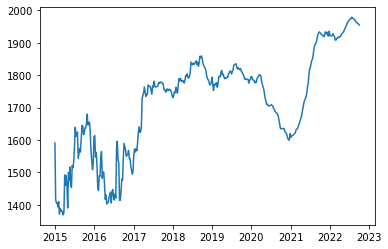

In [42]:
plt.plot(avg_ner_data['WEEK_START'], avg_ner_data['NER_T4'])

In [52]:
df = raot_cta_ner.copy()


d = {'NER':'Average'}

df=df.groupby(['WEEK_START']).agg({'NER_T4':'mean'})
df['date'] = df.index
df['date'] = pd.to_datetime(df['date']).dt.date

split_date = date(2022, 4, 11)

df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()


df_train = datetime_index(df_train, 'date')
df_test = datetime_index(df_test, 'date')

X_train, y_train = create_features(df_train, label='NER_T4')
X_test, y_test = create_features(df_test, label='NER_T4')

In [53]:
X_train, y_train = create_features(df_train, label='NER_T4')
X_test, y_test = create_features(df_test, label='NER_T4')

In [54]:
reg = xgb.XGBRegressor(n_estimators=200)
reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

df_test['Prediction'] = reg.predict(X_test)

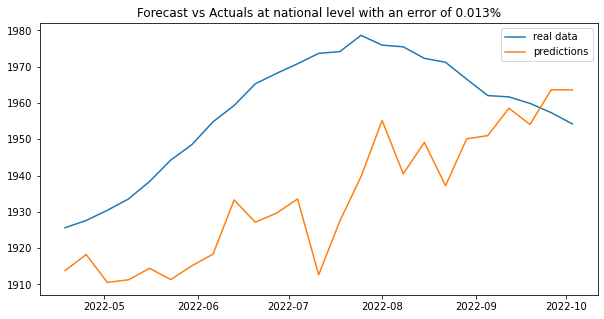

In [59]:
mape = evaluation(df_test['NER_T4'], df_test['Prediction'])

plt.figure(figsize=(10, 5))
plt.plot(df_test['NER_T4'], label = 'real data')
plt.plot(df_test['Prediction'], label = 'predictions')
plt.legend()
plt.title(f'Forecast vs Actuals at national level with an error of {round((mape),3)}%')
plt.show()

# MSA

In [60]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

In [32]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4')

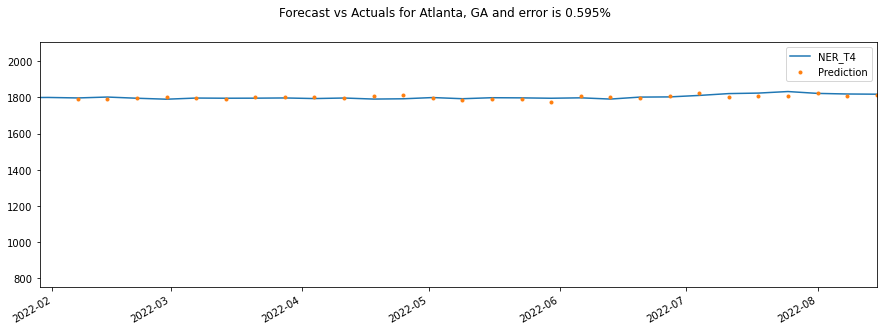

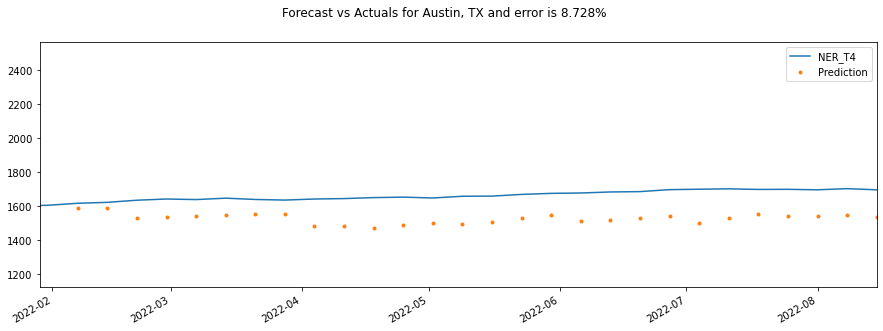

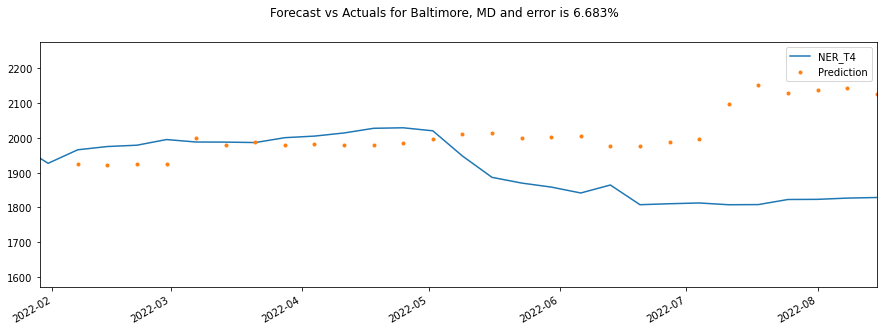

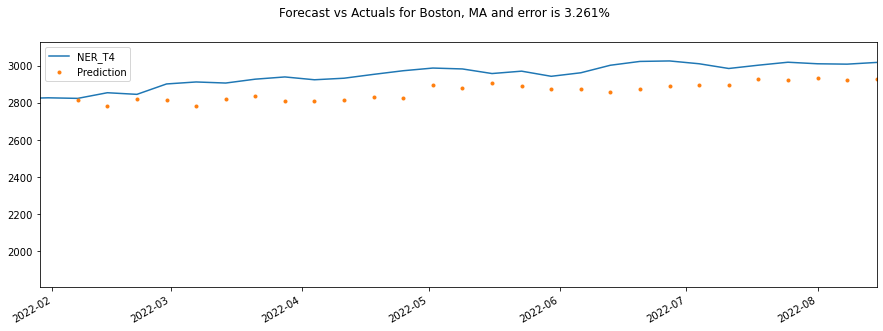

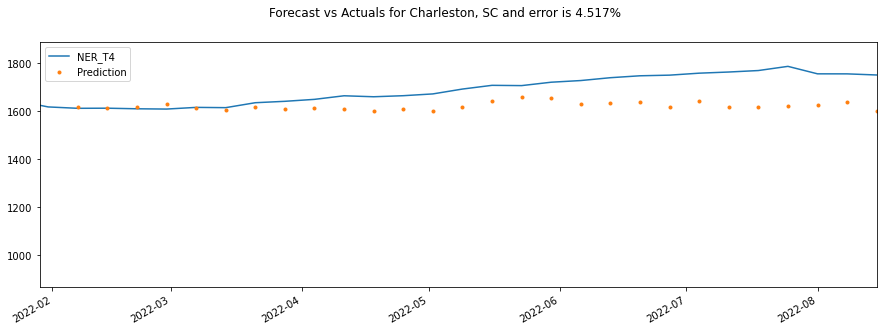

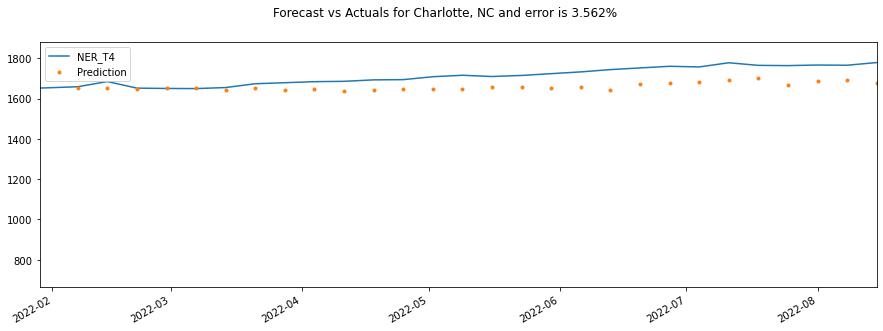

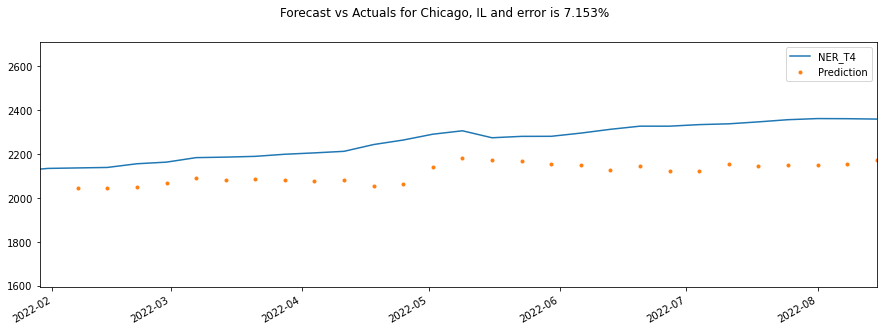

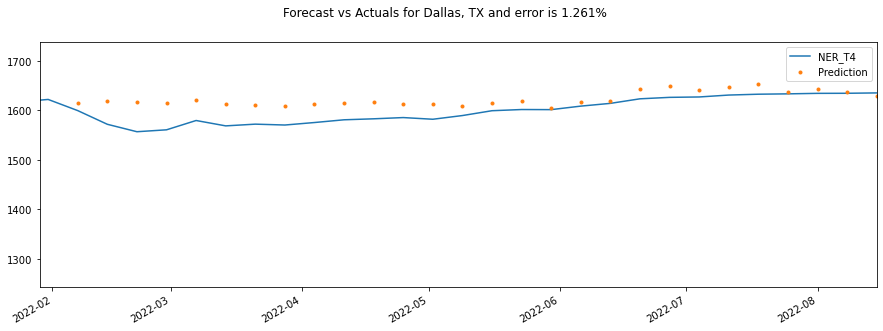

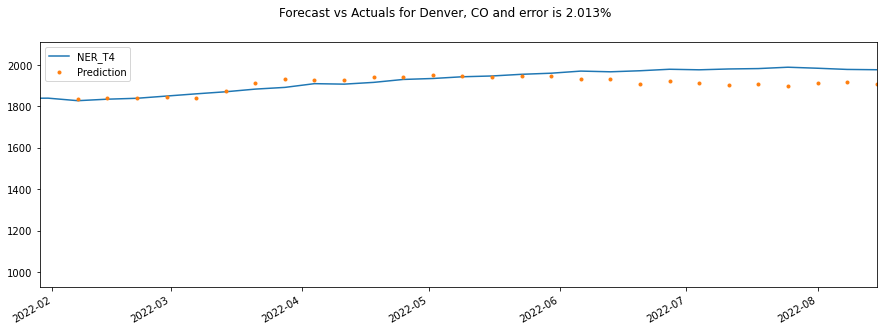

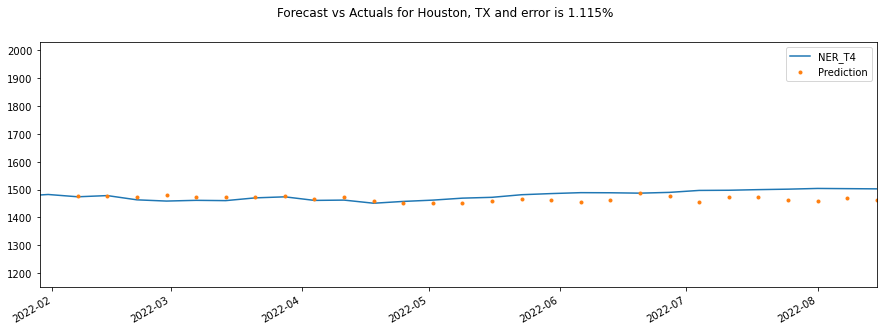

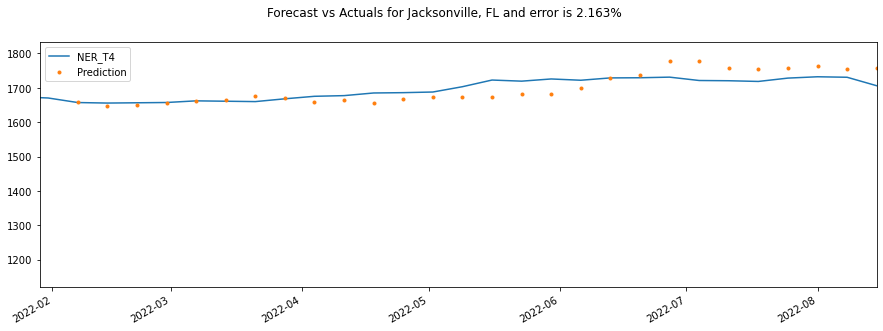

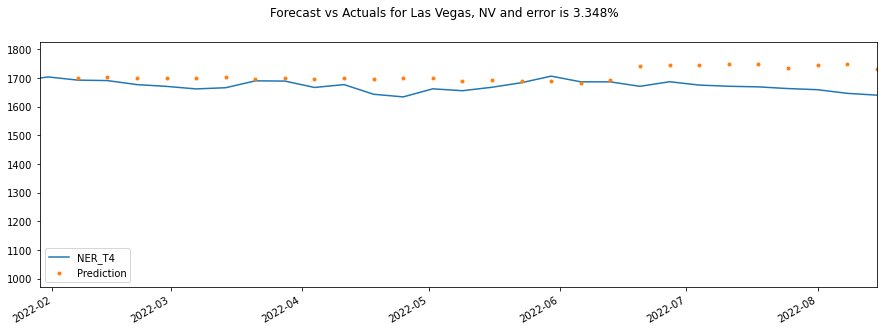

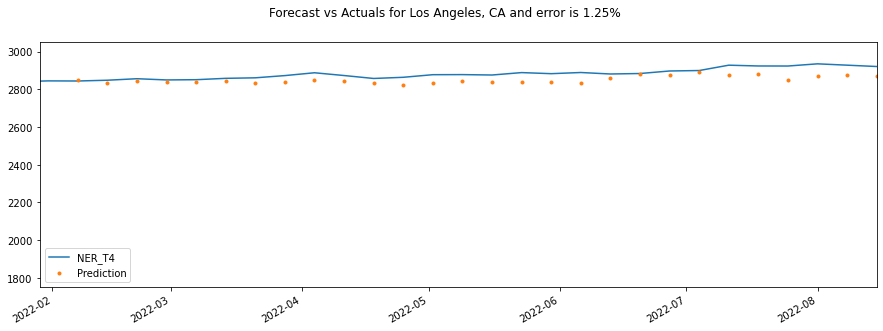

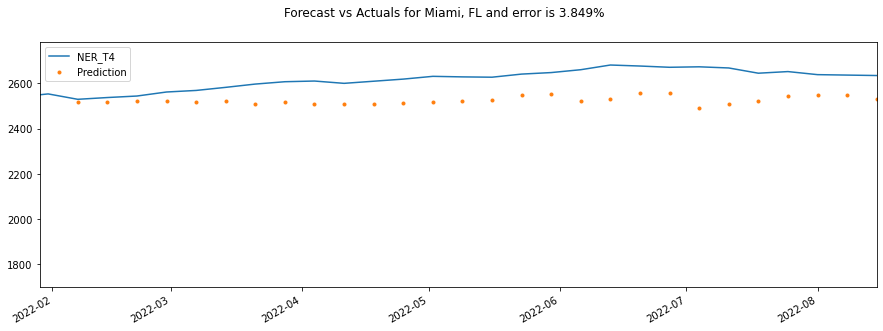

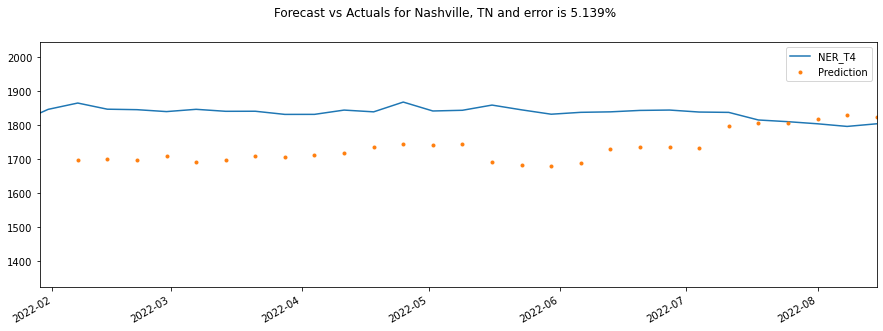

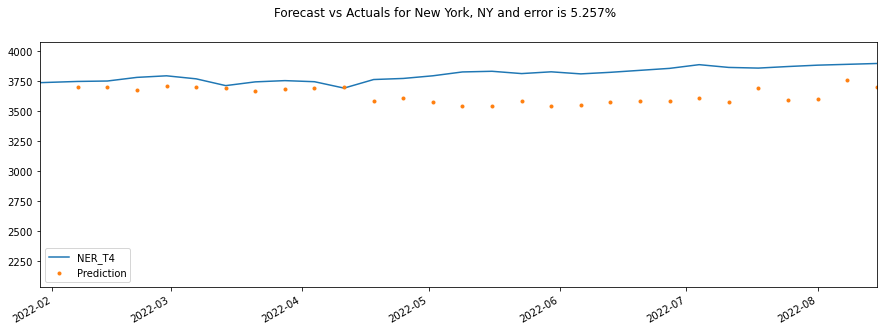

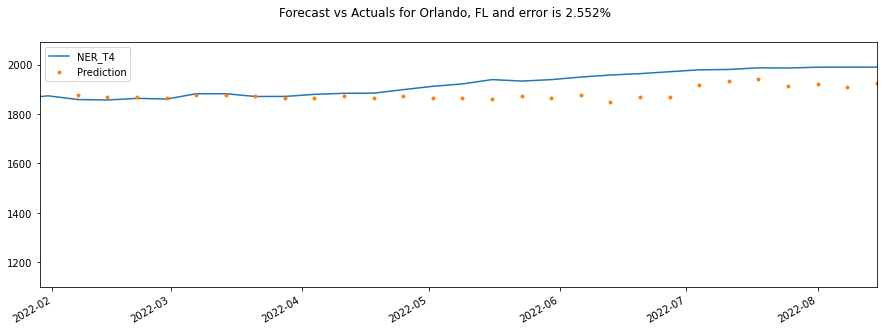

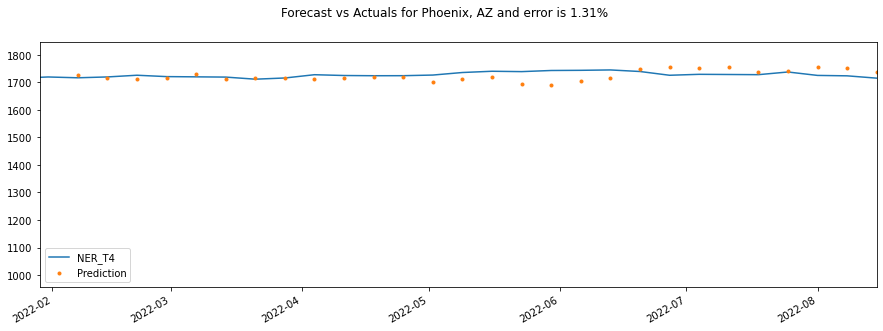

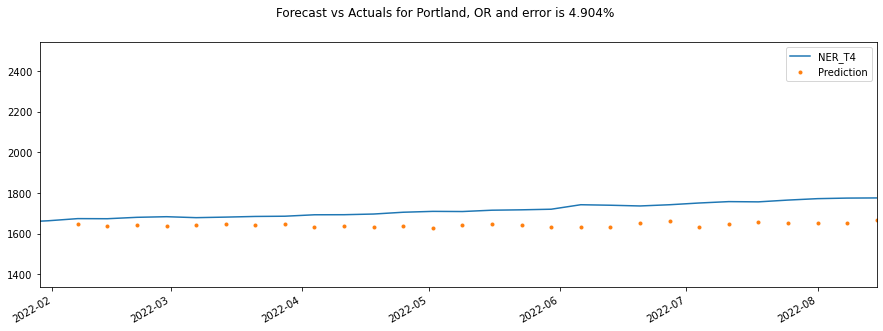

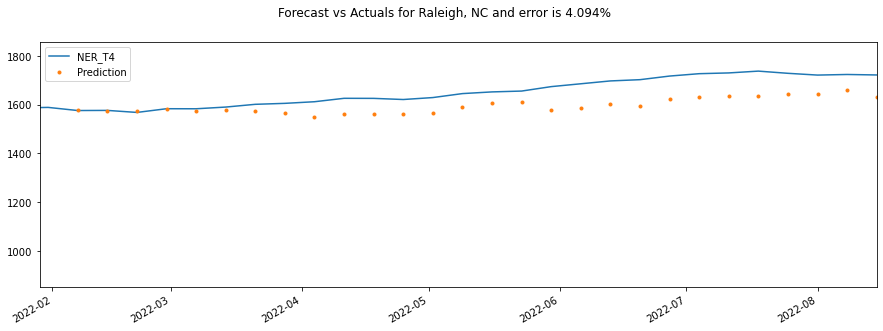

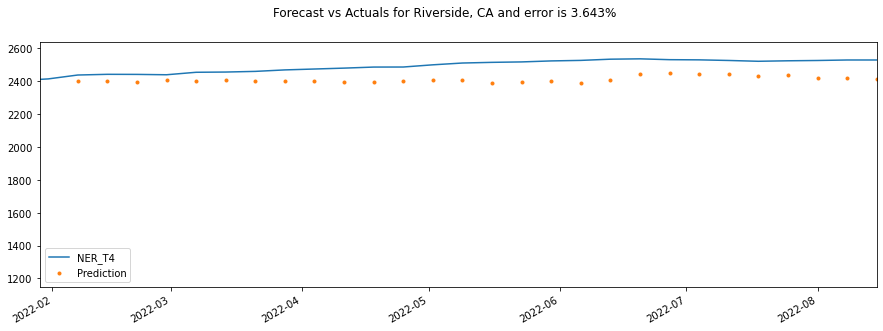

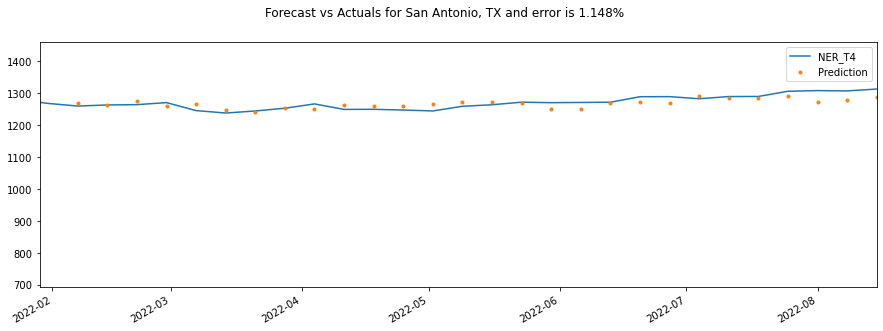

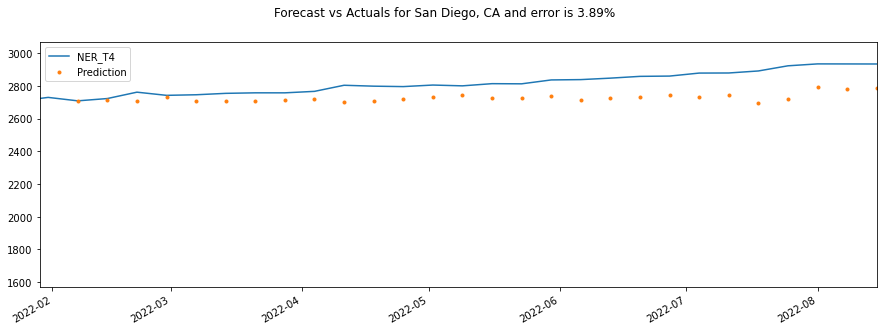

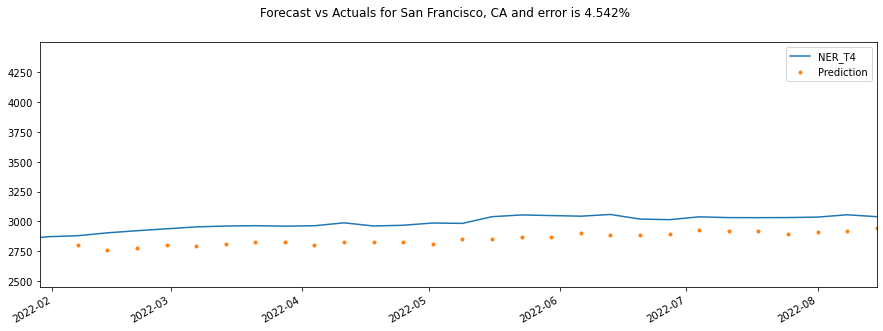

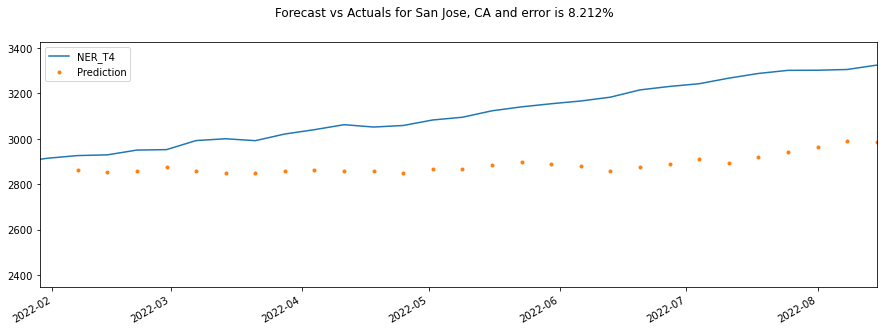

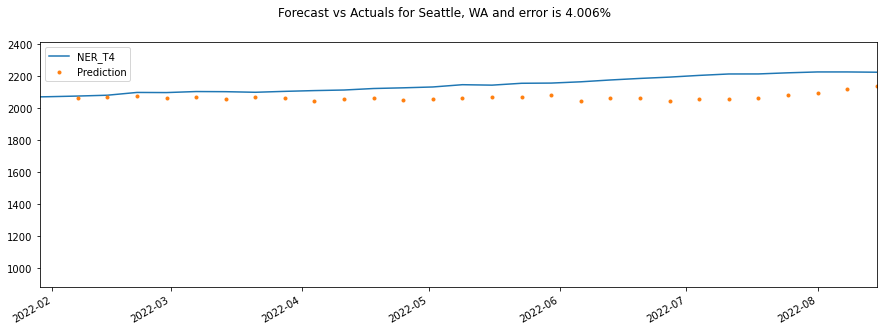

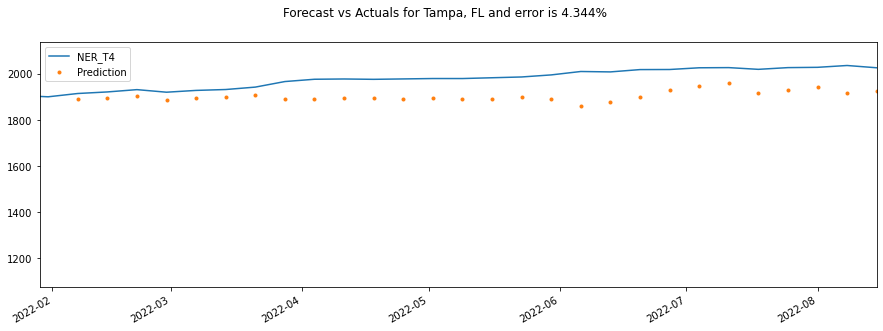

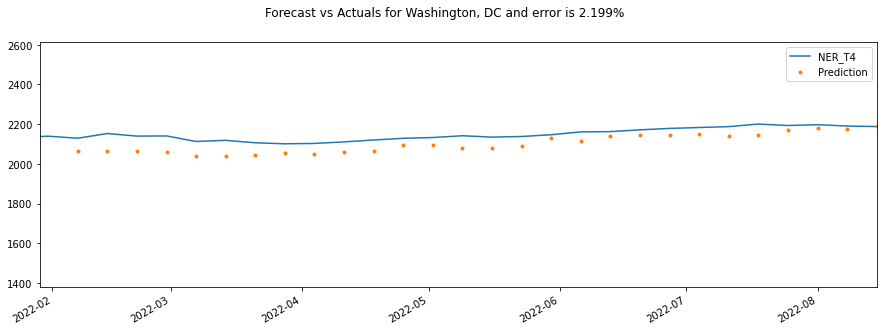

In [33]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst: 
        split_date = date(2022, 2, 1)
        subset['date'] = subset.index
        df_train = subset.loc[subset.index <= split_date].copy()
        df_test = subset.loc[subset.index > split_date].copy()
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        X_train, y_train = create_features(df_train, label='NER_T4')

        X_test, y_test = create_features(df_test, label='NER_T4')
        reg = xgb.XGBRegressor(n_estimators=200)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape = evaluation(df_test['NER_T4'], df_test['Prediction'])

        if mape < 0.10:
            f, ax = plt.subplots(1)
            f.set_figheight(5)
            f.set_figwidth(15)
            _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','.'])


            ax.set_xbound(lower='01-29-2022', upper='08-15-2022')
            ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

            plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

**Extracting the data into a df**

In [35]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_xgboost = pd.DataFrame(columns = column_names)
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score


In [36]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)

                
        algorithm_name = 'XGBoost Model'
        
        ## experimenting with a dataset
        prediction_period = 25
        
        
        df_train = subset[:-prediction_period]
        df_test = subset[-prediction_period:]
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        
        X_train, y_train = create_features(df_train, label='NER_T4')
        X_test, y_test = create_features(df_test, label='NER_T4')
        
        
        reg = xgb.XGBRegressor(n_estimators=500)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape_score = evaluation(df_test['NER_T4'], df_test['Prediction'])

                
        #print(df_test.reset_index()['index'])
        
        df['Actuals'] =  df_test['NER_T4']
        df['Predictions'] =  df_test['Prediction']
        df['MAPE score'] =  mape_score
        df['Time'] =  list(df_test.reset_index()['index'])
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val

        df_xgboost = df_xgboost.append(df, ignore_index=True)

In [71]:
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score,Hash Column
0,XGBoost Model,2022-04-18,"Atlanta, GA",1790.830447,1788.161377,0.009998,"Atlanta, GA2022-04-18"
1,XGBoost Model,2022-04-25,"Atlanta, GA",1792.420025,1793.037720,0.009998,"Atlanta, GA2022-04-25"
2,XGBoost Model,2022-05-02,"Atlanta, GA",1799.222625,1787.461182,0.009998,"Atlanta, GA2022-05-02"
3,XGBoost Model,2022-05-09,"Atlanta, GA",1792.786981,1785.534790,0.009998,"Atlanta, GA2022-05-09"
4,XGBoost Model,2022-05-16,"Atlanta, GA",1798.340909,1788.880981,0.009998,"Atlanta, GA2022-05-16"
...,...,...,...,...,...,...,...
695,XGBoost Model,2022-09-05,"Washington, DC",2171.473456,2163.037109,0.015959,"Washington, DC2022-09-05"
696,XGBoost Model,2022-09-12,"Washington, DC",2173.625605,2169.740723,0.015959,"Washington, DC2022-09-12"
697,XGBoost Model,2022-09-19,"Washington, DC",2171.713568,2156.151855,0.015959,"Washington, DC2022-09-19"
698,XGBoost Model,2022-09-26,"Washington, DC",2171.963422,2164.699219,0.015959,"Washington, DC2022-09-26"


In [70]:
df_xgboost['Hash Column'] = df_xgboost['MSA'] + df_xgboost['Time'].astype(str)

In [72]:
df_xgboost.to_csv("df_xgboost_msa_level_SAME_STORE.csv")